In [1]:
from __future__ import print_function

import argparse
import os

import random

import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as Dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader 
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.utils import save_image
print(torch.cuda.is_available())
print(torch.version.cuda)
from torch.nn import functional as F

True
11.3


# DCGAN

In [2]:

bitmoji_path = "/home/liyana/disk/liyana/adrl_a1/data/bitmoji"
batch_size = 128
image_size = 64
num_ch = 3
latent_dim = 100

lr = 0.0002

preprocessData = transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize([0.5],[0.5])
                            ])

dataset = Dataset.ImageFolder(root=bitmoji_path, transform=preprocessData)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print("Device being used is: ", device)

def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

Device being used is:  cuda:0


In [11]:

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.decode = nn.Sequential(
            #Input = [num_ch x 64 x 64] 
            nn.Conv2d(num_ch, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            #Output = [1 x 1 x 1]
        )

    def forward(self, input):
        out = self.decode(input)
        return out

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encode = nn.Sequential(
            #Input = [100 x 1 x 1] 
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d( 512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d( 256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(n128),
            nn.ReLU(True),
            nn.ConvTranspose2d( 128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64, num_ch, 4, 2, 1, bias=False),
            nn.Tanh()
            #Output = [num_ch x 64 x 64] 
        )

    def forward(self, input):
        out = self.encode(input)
        return out

D = Discriminator().to(device)
G = Generator().to(device)
D.apply(init_weights)
G.apply(init_weights)
print(D)
print(G)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)
Generator(
  (main): Sequentia

In [12]:

loss = nn.BCELoss()


optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

real_label = 1.
fake_label = 0.

losses_g = []
losses_d = []

print("Training DCGAN...")
num_epochs = 5
steps = 0
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        
        # Train D with real batch
        D.zero_grad()
        real_img = data[0].to(device)
        current_bs = real_img.size(0)
        label = torch.full((current_bs,), real_label, dtype=torch.float, device=device)

        output = D(real_img).view(-1)
        loss_Dreal = loss(output, label)
        loss_Dreal.backward()

        # Train D with generated images 
        noise = torch.randn(current_bs, latent_dim, 1, 1, device=device)

        fake = G(noise)
        label.fill_(fake_label)
        output = D(fake.detach()).view(-1)
        loss_Dfake = loss(output, label)

        loss_Dfake.backward()
        lossD = loss_Dreal + loss_Dfake
        optimizerD.step()

        # Train G 
        G.zero_grad()
        label.fill_(real_label)  
        output = D(fake).view(-1)
        lossG = loss(output, label)
        lossG.backward()
        optimizerG.step()

        losses_g.append(lossG.item())
        losses_d.append(lossD.item())
        

        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f' % (epoch, num_epochs, i, len(dataloader), lossD.item(), lossG.item()))
            
        steps += 1

Starting Training Loop...
[0/5][0/1018]	Loss_D: 2.7311	Loss_G: 1.5704	D(x): 0.1066	D(G(z)): 0.1292 / 0.2774
[0/5][50/1018]	Loss_D: 0.0004	Loss_G: 14.4735	D(x): 0.9996	D(G(z)): 0.0000 / 0.0000
[0/5][100/1018]	Loss_D: 0.0000	Loss_G: 39.5407	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][150/1018]	Loss_D: 0.0000	Loss_G: 34.0223	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[0/5][200/1018]	Loss_D: 0.5545	Loss_G: 8.1192	D(x): 0.9302	D(G(z)): 0.3206 / 0.0008
[0/5][250/1018]	Loss_D: 0.5966	Loss_G: 6.8014	D(x): 0.6244	D(G(z)): 0.0037 / 0.0015
[0/5][300/1018]	Loss_D: 0.1081	Loss_G: 3.5417	D(x): 0.9589	D(G(z)): 0.0535 / 0.0388
[0/5][350/1018]	Loss_D: 0.4982	Loss_G: 2.8482	D(x): 0.7746	D(G(z)): 0.1484 / 0.0747
[0/5][400/1018]	Loss_D: 0.6601	Loss_G: 3.1900	D(x): 0.6090	D(G(z)): 0.0188 / 0.0786
[0/5][450/1018]	Loss_D: 0.2165	Loss_G: 4.9437	D(x): 0.9535	D(G(z)): 0.1423 / 0.0093
[0/5][500/1018]	Loss_D: 0.3912	Loss_G: 3.5851	D(x): 0.8686	D(G(z)): 0.1998 / 0.0338
[0/5][550/1018]	Loss_D: 1.0127	Loss_G: 6.8346	D(x)

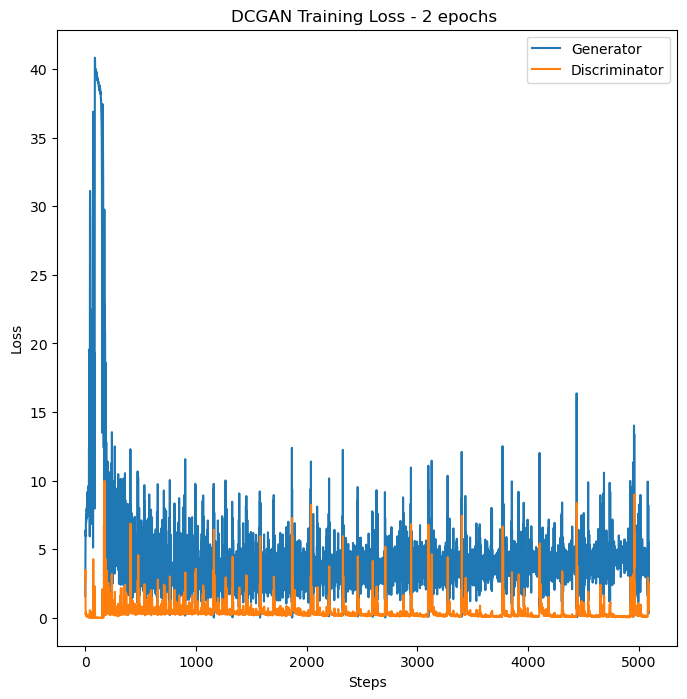

In [13]:
plt.figure(figsize=(8,8))
plt.title("DCGAN Training Loss - 2 epochs ")
plt.plot(losses_g,label="Generator")
plt.plot(losses_d,label="Discriminator")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

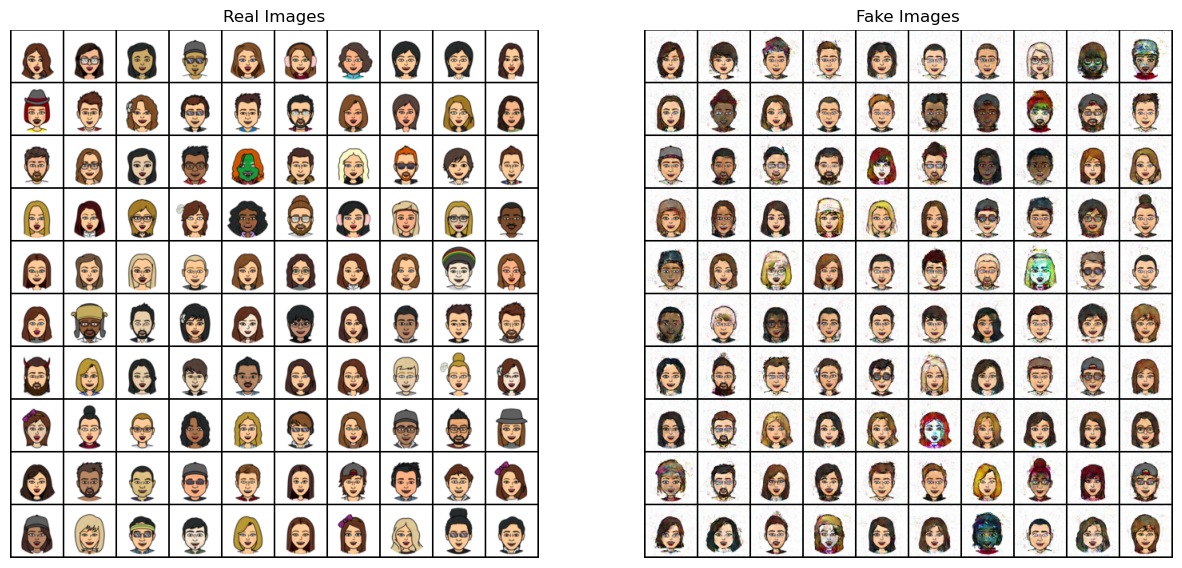

In [14]:
z = torch.randn(100, latent_dim, 1, 1, device=device)
with torch.no_grad():
    fake = G(z).detach().cpu()
fake.shape

plt.axis("off")
plt.title("Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake, nrow=10, normalize=True), (1,2,0)))
plt.show()

In [15]:
##Save images to calculate FID
preprocessInception = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

z = torch.randn(1000, latent_dim, 1, 1, device=device)
with torch.no_grad():
    fake = G(z).detach().cpu()
for i, img in enumerate(fake, 0):
    img = preprocessInception(img)
    save_image(img, f'./results/DCGAN/fake/image_{i}.png')

sampled = torch.utils.data.RandomSampler(dataset, replacement=False, num_samples=1000, generator=None)
# sampled
dataSampled = DataLoader(dataset, batch_size=1000, sampler=sampled)
real_batch = next(iter(dataSampled))
# real_batch[0].size()
for i, img in enumerate(real_batch[0]):
    img = preprocessInception(img)
    save_image(img, f'./results/DCGAN/real/image_{i}.png')

-1
torch.Size([100, 3, 64, 64])


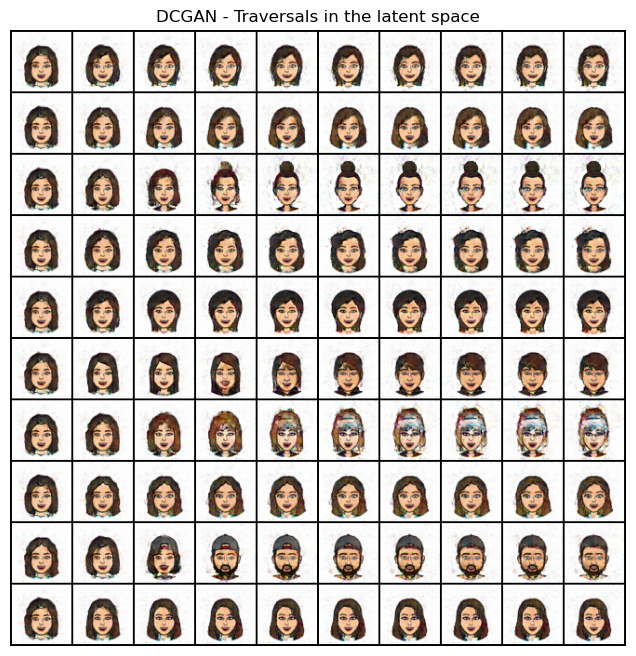

In [17]:

#Latent Traversal
z = torch.randn(1, latent_dim, 1, 1, device=device)
Z = torch.zeros((0, 100, 1, 1))
image_grid = torch.zeros((0, 3, 64, 64))
val = -1

for j in range(10):
    for i in range(10):
        new_z = z.clone().detach()
        new_z[:,j*10,:,:] = val + 5*i
    
        gen_img = G(new_z).cpu()
        Z = torch.cat((Z, new_z.cpu()))
        image_grid = torch.cat((image_grid, gen_img))

print(image_grid.shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("DCGAN - Traversals in the latent space")
plt.imshow(np.transpose(vutils.make_grid(image_grid, nrow=10, normalize=True), (1,2,0)))
plt.show()



In [ ]:
#python -m pytorch_fid real fake --device cuda:0

## LSGAN

In [20]:
class DiscriminatorLS(nn.Module):
    def __init__(self):
        super(DiscriminatorLS, self).__init__()
        self.encode = nn.Sequential(
            nn.Conv2d(num_ch, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            # nn.Sigmoid()
        )

    def forward(self, input):
        out = self.encode(input)
        out = out.view(out.shape[0], -1)
        return out


D = DiscriminatorLS().to(device)
D.apply(init_weights)
G.apply(init_weights)


print(D)

loss = nn.MSELoss()

optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

losses_g = []
losses_d = []

print("Starting LSGAN...")
steps = 0
num_epochs = 5
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        
        # Train D with real batch
        D.zero_grad()
        real_img = data[0].to(device)
        current_bs = real_img.size(0)
        label = torch.full((current_bs,), real_label, dtype=torch.float, device=device)

        output = D(real_img).view(-1)
        loss_Dreal = loss(output, label)
        loss_Dreal.backward()

        # Train D with generated images 
        noise = torch.randn(current_bs, latent_dim, 1, 1, device=device)

        fake = G(noise)
        label.fill_(fake_label)
        output = D(fake.detach()).view(-1)
        loss_Dfake = loss(output, label)

        loss_Dfake.backward()
        lossD = loss_Dreal + loss_Dfake
        optimizerD.step()

        # Train G 
        G.zero_grad()
        label.fill_(real_label)  
        output = D(fake).view(-1)
        lossG = loss(output, label)
        lossG.backward()
        optimizerG.step()

        losses_g.append(lossG.item())
        losses_d.append(lossD.item())
        

        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f' % (epoch, num_epochs, i, len(dataloader), lossD.item(), lossG.item()))
            
        steps += 1

DiscriminatorLS(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)
Starting Training Loop...
[0/5][0/1018]	Loss_D: 

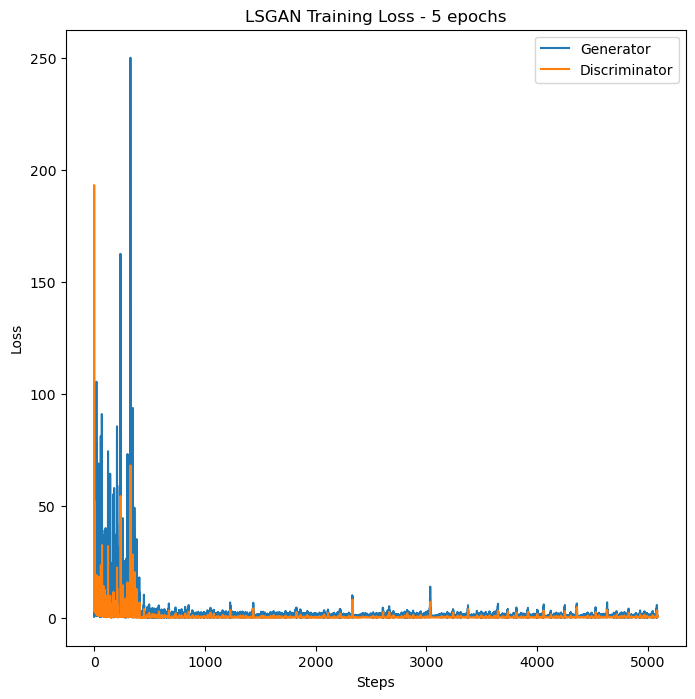

In [21]:
plt.figure(figsize=(8,8))
plt.title("LSGAN Training Loss - 5 epochs")
plt.plot(losses_g,label="Generator")
plt.plot(losses_d,label="Discriminator")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

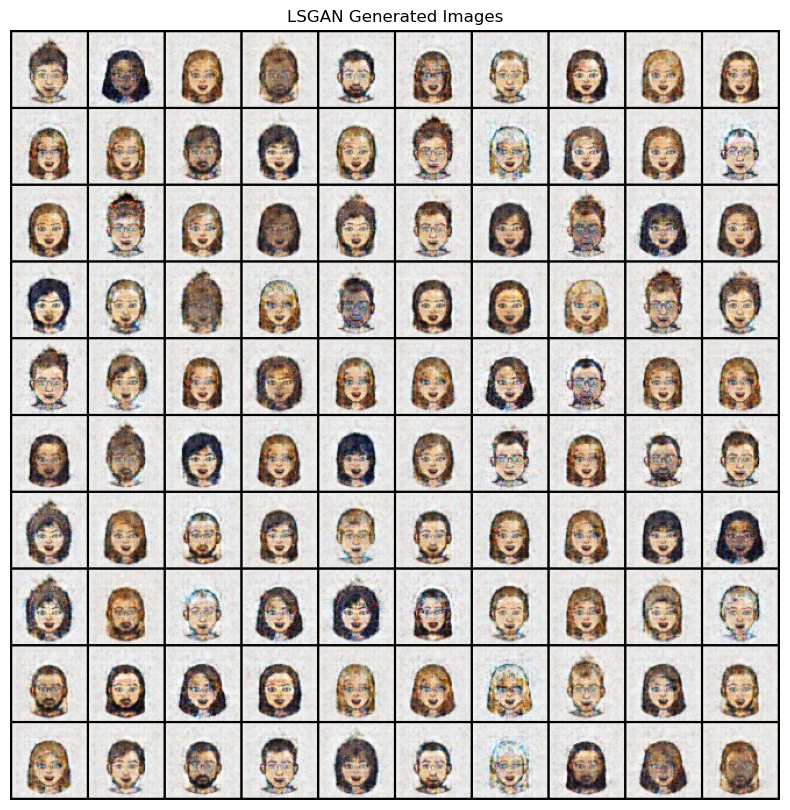

In [22]:
z = torch.randn(100, latent_dim, 1, 1, device=device)
with torch.no_grad():
    fake = G(z).detach().cpu()

fake.shape
# Plot the real images
plt.figure(figsize=(10,10))
plt.title("LSGAN Generated Images")
plt.imshow(np.transpose(vutils.make_grid(fake, nrow=10, normalize=True), (1,2,0)))
plt.axis("off")
plt.show()

In [23]:
##Save images to calculate FID
preprocessInception = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

z = torch.randn(1000, latent_dim, 1, 1, device=device)
with torch.no_grad():
    fake = G(z).detach().cpu()
for i, img in enumerate(fake, 0):
    img = preprocessInception(img)
    save_image(img, f'./results/LSGAN5/fake/image_{i}.png')

sampled = torch.utils.data.RandomSampler(dataset, replacement=False, num_samples=1000, generator=None)
# sampled
dataSampled = DataLoader(dataset, batch_size=1000, sampler=sampled)
real_batch = next(iter(dataSampled))
# real_batch[0].size()
for i, img in enumerate(real_batch[0]):
    img = preprocessInception(img)
    save_image(img, f'./results/LSGAN5/real/image_{i}.png')

-1
torch.Size([100, 3, 64, 64])


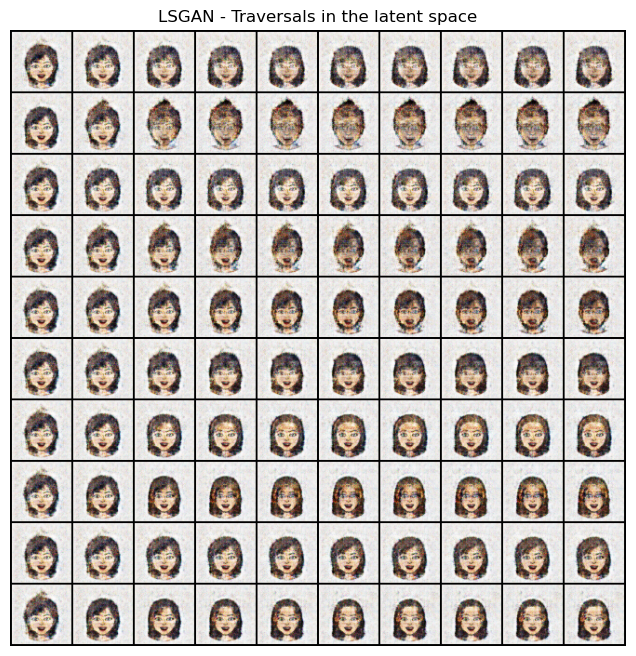

In [26]:


# Latent Traversal code
z = torch.randn(1, latent_dim, 1, 1, device=device)
Z = torch.zeros((0, 100, 1, 1))
image_grid = torch.zeros((0, 3, 64, 64))
val = -1

for j in range(10):
    for i in range(10):
        new_z = z.clone().detach()
        to_add = (5)*i

        new_z[:,j*10,:,:] = val + to_add
        gen_img = G(new_z).cpu()
        Z = torch.cat((Z, new_z.cpu()))
        image_grid = torch.cat((image_grid, gen_img))

print(image_grid.shape)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("LSGAN - Traversals in the latent space")
plt.imshow(np.transpose(vutils.make_grid(image_grid, nrow=10, normalize=True), (1,2,0)))
plt.show()




## BiGAN

In [3]:
from torch.autograd import Variable

In [4]:

num_epochs = 5
lr = 0.0002

dataset = Dataset.ImageFolder(root=bitmoji_path, transform=preprocessData)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
print("Device being used is: ", device)

Device being used is:  cuda:0


In [5]:


class DiscriminatorBi(nn.Module):
    def __init__(self):
        super(DiscriminatorBi, self).__init__()
        self.encode_img = nn.Sequential(

            nn.Conv2d(num_ch, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 4, 1, 0, bias=False),
        )

        self.encode_z = nn.Sequential(
                nn.Conv2d(100, 512, 1, 1, 0), 
                nn.LeakyReLU(0.2),
                nn.Conv2d(512, 512, 1, 1, 0), 
                nn.LeakyReLU(0.2)
            )
            
        self.encode = nn.Sequential(
                nn.Conv2d(1024, 2048, 1, 1, 0), 
                nn.LeakyReLU(0.2),
                nn.Conv2d(2048, 2048, 1, 1, 0), 
                nn.LeakyReLU(0.2),
                nn.Conv2d(2048, 1, 1, 1, 0),
                nn.Sigmoid()
            )

    def forward(self, x, z):

        input = self.encode_img(x)
        latent = self.encode_z(z)
        out = self.encode(torch.cat((input, latent), dim=1))
        return out

    # def forward(self, input, z):
    #     input = torch.cat((input,z.view(input.shape[0],1,64,64)), dim=1)
    #     return self.encode(input)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.generate = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d( 512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d( 256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d( 128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d( 64, num_ch, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output : [num_ch x 64 x 64] 

        )

    def forward(self, input):
        out =  self.generate(input)
        return out



class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encode = nn.Sequential(
            
            nn.Conv2d(num_ch, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 512, 4, 1, 0, bias=False),
            nn.LeakyReLU(0.2),
            nn.Conv2d(ndf * 8, 100, 1, 1, 0, bias=False),
            # nn.ReLU(True),
            # nn.Sigmoid()
        )

    def forward(self, input):
        out =  self.encode(input)
        return out

D = DiscriminatorBi().to(device)
G = Generator().to(device)
Enc = Encoder().to(device)
D.apply(init_weights)
G.apply(init_weights)
Enc.apply(init_weights)
print(D)
print(G)

DiscriminatorBi(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
  (fz): Sequential(
    (0): Conv2d(100, 512, kernel_size=(1, 1), stride=(1, 1))
    (1): LeakyReLU(nega

In [6]:
torch.autograd.set_detect_anomaly(True)

In [ ]:

loss = nn.BCELoss()

def D_loss(DG, DE, eps=1e-6):
    loss = torch.log(DE + eps) + torch.log(1 - DG + eps)
    return -torch.mean(loss)

def EG_loss(DG, DE, eps=1e-6):
    loss = torch.log(DG + eps) + torch.log(1 - DE + eps)
    return -torch.mean(loss)
      
optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerEG = optim.Adam(list(G.parameters())+list(Enc.parameters()), lr=lr, betas=(0.5, 0.999))

losses_g = []
losses_d = []


print("Starting Training Loop...")
steps = 0
num_epochs = 2
with torch.autograd.set_detect_anomaly(True):
    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader, 0):
            real_data = data[0].float().to(device)
            current_bs = real_data.size(0)
            noise = torch.randn(current_bs, latent_dim,1,1, device=device)
            label = torch.full((current_bs,), real_label, device=device).float()
            
        
            steps = 8
            #Train D
            for j in range(steps):
                D.zero_grad()
                
                real_z = Enc(real_data)
                output_real = D(real_data, real_z).view(-1).to(device)
                loss_Dreal = loss(output_real, label)
                loss_Dreal.backward(retain_graph=True)

                noise = torch.randn(current_bs, latent_dim,1,1, device=device)

                fake_data = G(noise)
                label.fill_(fake_label)
                output = D(fake_data.detach(), Enc(fake_data)).view(-1).to(device)
                loss_Dfake = loss(output, label)
                loss_Dfake.backward()
                lossD= loss_Dreal + loss_Dfake
                optimizerD.step()
            
            #Train G and E
            G.zero_grad()
            fake_data = G(noise)
            label.fill_(real_label)
            real_z = Enc(real_data)
            output = D(fake_data, Enc(fake_data)).view(-1).to(device)
            outputR = D(real_data, real_z).view(-1).to(device)
            loss_Gfake = loss(output, label)
            loss_Greal = loss(outputR, label)
            lossG = loss_Gfake + loss_Greal
            lossG.backward()
            optimizerEG.step()


            if i%100 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f' % (epoch, num_epochs, i, len(dataloader), lossD.item(), lossG.item()))

            losses_g.append(lossG.item())
            losses_d.append(lossD.item())

        steps += 1

In [ ]:
plt.figure(figsize=(8,8))
plt.title("BiGAN Training Loss")
plt.plot(losses_g,label="Generator")
plt.plot(losses_d,label="Discriminator")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
z = torch.randn(100, latent_dim, 1, 1, device=device)
with torch.no_grad():
    fake = G(z).detach().cpu()

fake.shape

plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake, nrow=10, normalize=True), (1,2,0)))
plt.show()

In [ ]:
##Save images to calculate FID

z = torch.randn(1000, latent_dim, 1, 1, device=device)
with torch.no_grad():
    fake = G(z).detach().cpu()
for i, img in enumerate(fake, 0):
    save_image(img, f'./results/BiGAN/fake/image_{i}.png')

sampled = torch.utils.data.RandomSampler(dataset, replacement=False, num_samples=1000, generator=None)
dataSampled = DataLoader(dataset, batch_size=1000, sampler=sampled)
real_batch = next(iter(dataSampled))
real_batch[0].size()

for i, img in enumerate(real_batch[0]):
    save_image(img, f'./results/BiGAN/real/image_{i}.png')

#python -m  pytorch_fid real fake --device cuda:0 